In [9]:
import os
import zipfile
import urllib.request
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.io import arff

# Directory where datasets will be downloaded and extracted
DATA_DIR = 'datasets'
os.makedirs(DATA_DIR, exist_ok=True)

def download_dataset(dataset_name, url):
    zip_path = os.path.join(DATA_DIR, f"{dataset_name}.zip")
    extract_dir = os.path.join(DATA_DIR, dataset_name)
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zp:
        zp.extractall(extract_dir)
    os.remove(zip_path)
    return extract_dir

def load_arff_data(file_path):
    raw, _ = arff.loadarff(file_path)
    return pd.DataFrame(raw)

def preprocess_data_df(train_paths, test_paths, valid_size=0.5, random_state=42):
    """
    Loads and preprocesses the SelfRegulationSCP1 ARFF dimensions into flat DataFrames:
      - Applies label mapping
      - Normalizes each dimension separately on training set
      - Stacks dimensions and flattens into 2D feature vectors
      - Splits test into validation and test sets

    Returns:
        X_train_df, y_train_srs,
        X_valid_df, y_valid_srs,
        X_test_df,  y_test_srs
    """
    # --- 1) Load all dimensions ---
    train_dfs = [load_arff_data(p) for p in train_paths]
    test_dfs  = [load_arff_data(p) for p in test_paths]

    # --- 2) Extract features & labels ---
    # Features: drop the 'cortical' label column
    train_feats = [df.drop(columns=['cortical']) for df in train_dfs]
    test_feats  = [df.drop(columns=['cortical']) for df in test_dfs]

    # Labels: map 'cortical' (bytes) to integer
    mapping = {b'negativity': 0, b'positivity': 1}
    y_train = train_dfs[0]['cortical'].map(mapping).astype(int)
    y_temp  = test_dfs[0]['cortical'].map(mapping).astype(int)

    # --- 3) Normalize each dimension separately ---
    scalers = [StandardScaler().fit(train_feats[i]) for i in range(len(train_feats))]
    train_norm = [scalers[i].transform(train_feats[i]) for i in range(len(train_feats))]
    test_norm  = [scalers[i].transform(test_feats[i])  for i in range(len(test_feats))]

    # --- 4) Stack into 3D arrays (n_samples, time_steps, dims) ---
    X_train_arr = np.stack(train_norm, axis=-1)
    X_temp_arr  = np.stack(test_norm,  axis=-1)

    # --- 5) Split temp into validation + test ---
    X_valid_arr, X_test_arr, y_valid, y_test = train_test_split(
        X_temp_arr, y_temp,
        test_size=valid_size,
        random_state=random_state,
        stratify=y_temp
    )

    # --- 6) Flatten to 2D (n_samples, time_steps*dims) ---
    n_t, n_d = X_train_arr.shape[1], X_train_arr.shape[2]
    X_train_flat = X_train_arr.reshape(-1, n_t * n_d)
    X_valid_flat = X_valid_arr.reshape(-1, n_t * n_d)
    X_test_flat  = X_test_arr.reshape(-1, n_t * n_d)

    # --- 7) Build column names and DataFrames ---
    cols = [f"t{{t}}_d{{d}}".format(t=t, d=d) for t in range(n_t) for d in range(n_d)]
    X_train_df = pd.DataFrame(X_train_flat, columns=cols)
    X_valid_df = pd.DataFrame(X_valid_flat, columns=cols)
    X_test_df  = pd.DataFrame(X_test_flat,  columns=cols)

    return X_train_df, y_train, X_valid_df, y_valid, X_test_df, y_test

# Example usage
if __name__ == '__main__':
    ds_name = 'SelfRegulationSCP1'
    url = 'https://timeseriesclassification.com/aeon-toolkit/SelfRegulationSCP1.zip'
    path = download_dataset(ds_name, url)
    train_arff = [os.path.join(path, f'{ds_name}Dimension{i+1}_TRAIN.arff') for i in range(6)]
    test_arff  = [os.path.join(path, f'{ds_name}Dimension{i+1}_TEST.arff')  for i in range(6)]

    X_train_df, y_train_srs, X_valid_df, y_valid_srs, X_test_df, y_test_srs = \
        preprocess_data_df(train_arff, test_arff)

    print('Shapes:', X_train_df.shape, y_train_srs.shape,
          X_valid_df.shape, y_valid_srs.shape,
          X_test_df.shape,  y_test_srs.shape)

Shapes: (268, 5376) (268,) (146, 5376) (146,) (147, 5376) (147,)


In [2]:
import embd_fgit as embd
import clasfy_p1 as clasfy
import clasfy_p2 as clasfy2
#import plot_umap as plt_um
import pandas as pd
import numpy

In [10]:
import plot_umap as plt_um

In [ ]:
def std_scaling(train_df, valid_df, test_df):
    """Applies Standard Scaling to the input DataFrames.

    Args:
        train_df (pd.DataFrame): The training DataFrame.
        valid_df (pd.DataFrame): The validation DataFrame.
        test_df (pd.DataFrame): The testing DataFrame.

    Returns:
        tuple: A tuple containing the scaled DataFrames (train_sc, valid_sc, test_sc).
    """
    # Reshape the 3D tensors to 2D for StandardScaler
    train_df_2d = train_df.reshape(train_df.shape[0], -1) # Reshape to (samples, time_steps * features)
    valid_df_2d = valid_df.reshape(valid_df.shape[0], -1)
    test_df_2d = test_df.reshape(test_df.shape[0], -1)

    scaler = StandardScaler()
    # Fit and transform on the training data
    scaled_data = scaler.fit_transform(train_df_2d)

    # Transform the validation and test data
    scaled_valid_data = scaler.transform(valid_df_2d)
    scaled_test_data = scaler.transform(test_df_2d)

    # Reshape back to 3D after scaling
    train_sc = scaled_data.reshape(train_df.shape)
    valid_sc = scaled_valid_data.reshape(valid_df.shape)
    test_sc = scaled_test_data.reshape(test_df.shape)

    return train_sc, valid_sc, test_sc

In [ ]:
from sklearn.preprocessing import StandardScaler # Make sure StandardScaler is imported

train_sc, val_sc, test_sc = std_scaling(X_train_df.numpy(), X_valid_df.numpy(), X_test.numpy()) # Remove extra indent

NameError: name 'X_train' is not defined

In [13]:
#Performing scaling of the datasets
train_sc, val_sc, test_sc = embd.std_scaling(X_train_df, X_valid_df, X_test_df)
#without overlapping windows
train_sct=train_sc
test_sct=test_sc
val_sct=val_sc
ny_train=y_train_srs
ny_test=y_test_srs
ny_val=y_valid_srs
ny_train2=y_train_srs-1
ny_test2=y_test_srs-1
ny_val2=y_valid_srs-1


In [12]:
#pca embedding
train_pca, val_pca, test_pca = embd.pca_embedding(train_sc, val_sc, test_sc,24)

In [14]:
#to save your embeddings
np.savetxt('tr_ep_pca_embeddings.txt', train_pca)
np.savetxt('te_ep_pca_embeddings.txt', test_pca)
np.savetxt('vl_ep_pca_embeddings.txt', val_pca)

/content/plot_umap.py:23: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


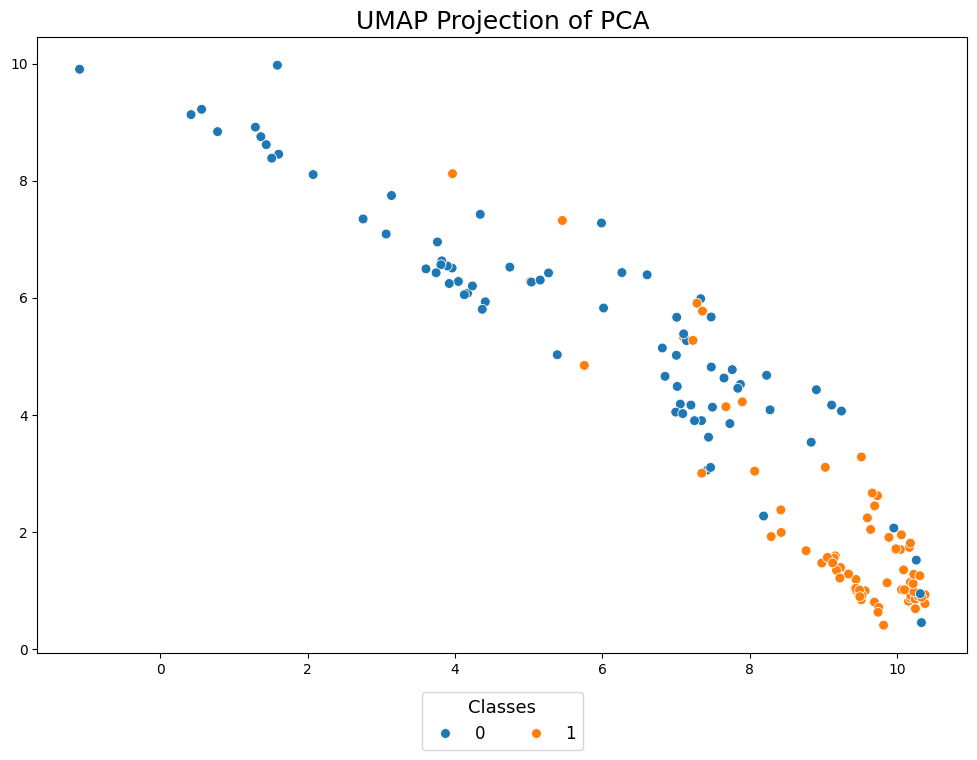

In [15]:
#to plot the umap visualization of the embedding
name='pca'
#to get the umap embedding
plt_um.umap_plt(train_pca, val_pca, test_pca, ny_train, ny_val, ny_test, 'PCA')

In [ ]:
#discrete wavelet transform
train_wt, val_wt, test_wt = embd.wavelet_embedding(train_sc, val_sc, test_sc)

In [ ]:
np.savetxt('tr_ep_wt_embeddings.txt', train_wt)
np.savetxt('te_ep_wt_embeddings.txt', test_wt)
np.savetxt('vl_ep_wt_embeddings.txt', val_wt)

/content/plot_umap.py:23: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


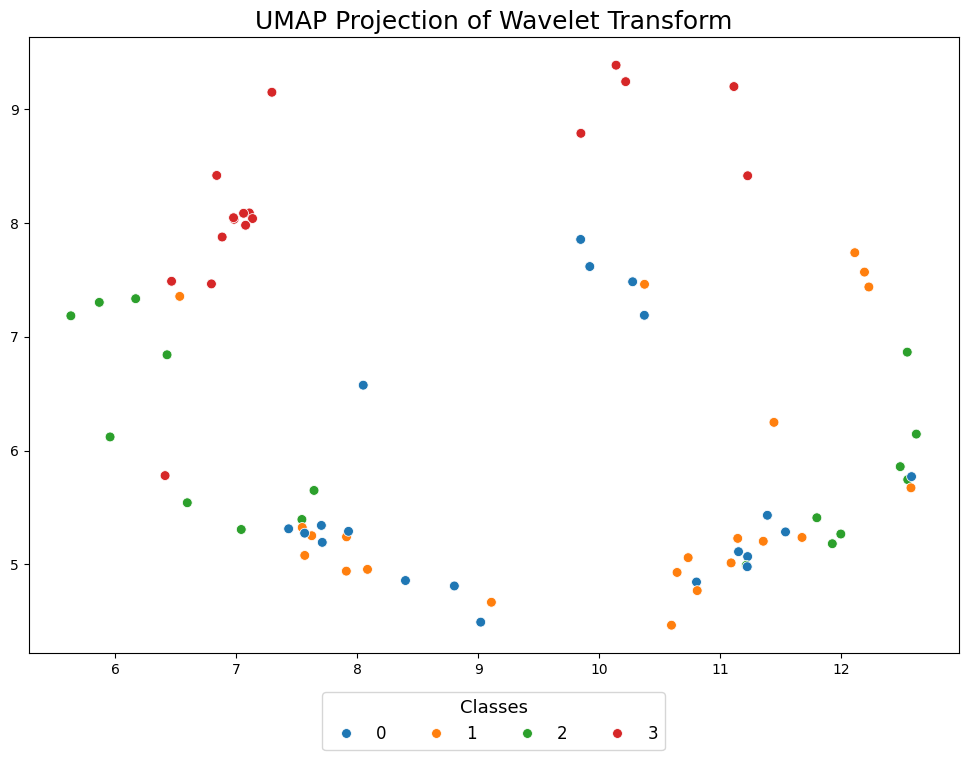

In [ ]:
#to get the umap embedding
plt_um.umap_plt(train_wt, val_wt, test_wt, ny_train, ny_val, ny_test, 'Wavelet Transform')

In [ ]:
#Fast Fourier Transform
train_fft, val_fft, test_fft = embd.fft_embedding(train_sc, val_sc, test_sc)

In [ ]:
np.savetxt('tr_ep_fft_embeddings.txt', train_fft)
np.savetxt('te_ep_fft_embeddings.txt', test_fft)
np.savetxt('vl_ep_fft_embeddings.txt', val_fft)

/content/plot_umap.py:23: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


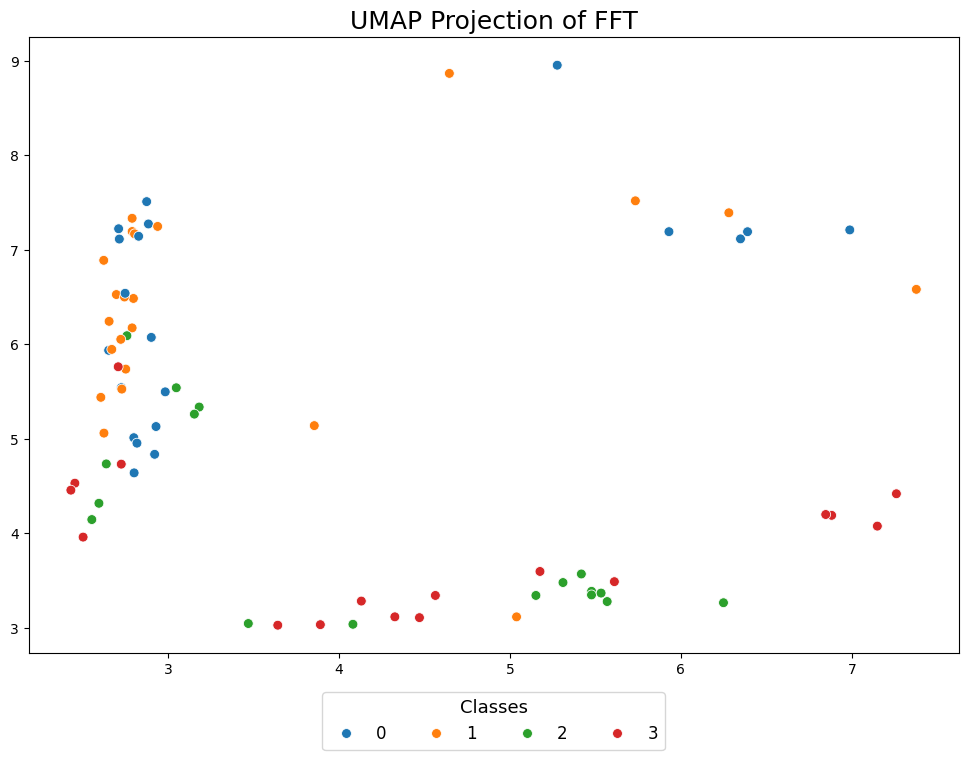

In [ ]:
#to get the umap embedding
plt_um.umap_plt(train_fft, val_fft, test_fft, ny_train, ny_val, ny_test, 'FFT')

In [ ]:
#Graph Embedding
#Based on the source paper and the algorithm discussed, this scaling method is used
train_mmc, val_mmc,test_mmc = embd.minmax_scaling(X_train_df, X_valid_df,X_test_df)
train_mml=train_mmc.values.tolist()
val_mml=val_mmc.values.tolist()
test_mml=test_mmc.values.tolist()

train_gr, val_gr, test_gr = embd.graph_embedding(train_mml, val_mml, test_mml)

In [ ]:
np.savetxt('tr_ep_gr_embeddings.txt', train_gr)
np.savetxt('te_ep_gr_embeddings.txt', test_gr)
np.savetxt('vl_ep_gr_embeddings.txt', val_gr)

/content/plot_umap.py:23: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


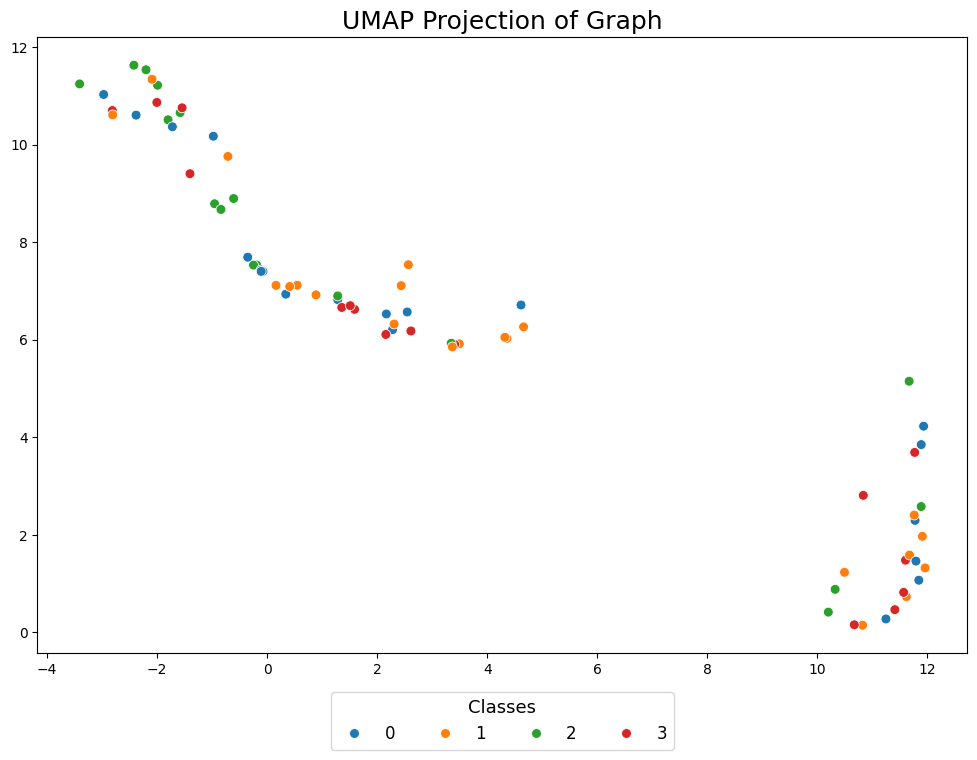

In [ ]:
#to get the umap embedding
plt_um.umap_plt(train_gr, val_gr, test_gr, ny_train, ny_val, ny_test, 'Graph')

In [ ]:
#TDA Embedding
train_tda,val_tda,test_tda = embd.tda_embedding(train_mml, val_mml, test_mml)

In [ ]:
np.savetxt('tr_ep_tda_embeddings.txt', train_tda)
np.savetxt('te_ep_tda_embeddings.txt', test_tda)
np.savetxt('vl_ep_tda_embeddings.txt', val_tda)

/content/plot_umap.py:23: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


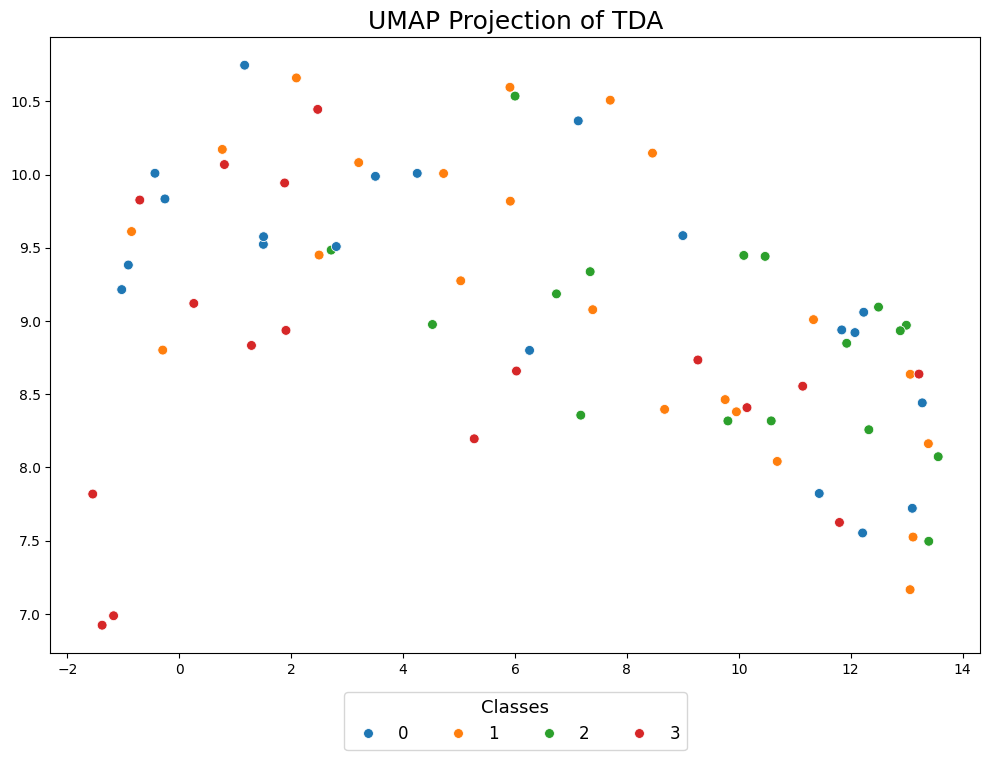

In [ ]:
#to get the umap embedding
plt_um.umap_plt(train_tda,val_tda, test_tda, ny_train, ny_val, ny_test, 'TDA')

In [ ]:
#LLE Embedding
train_lle, val_lle, test_lle = embd.lle_embedding(train_sc, val_sc, test_sc,{'n_components':64, 'n_neighbors':5,'random_state':12})

In [ ]:
np.savetxt('tr_ep_lle_embeddings.txt', train_lle)
np.savetxt('te_ep_lle_embeddings.txt', test_lle)
np.savetxt('vl_ep_lle_embeddings.txt', val_lle)

/content/plot_umap.py:23: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


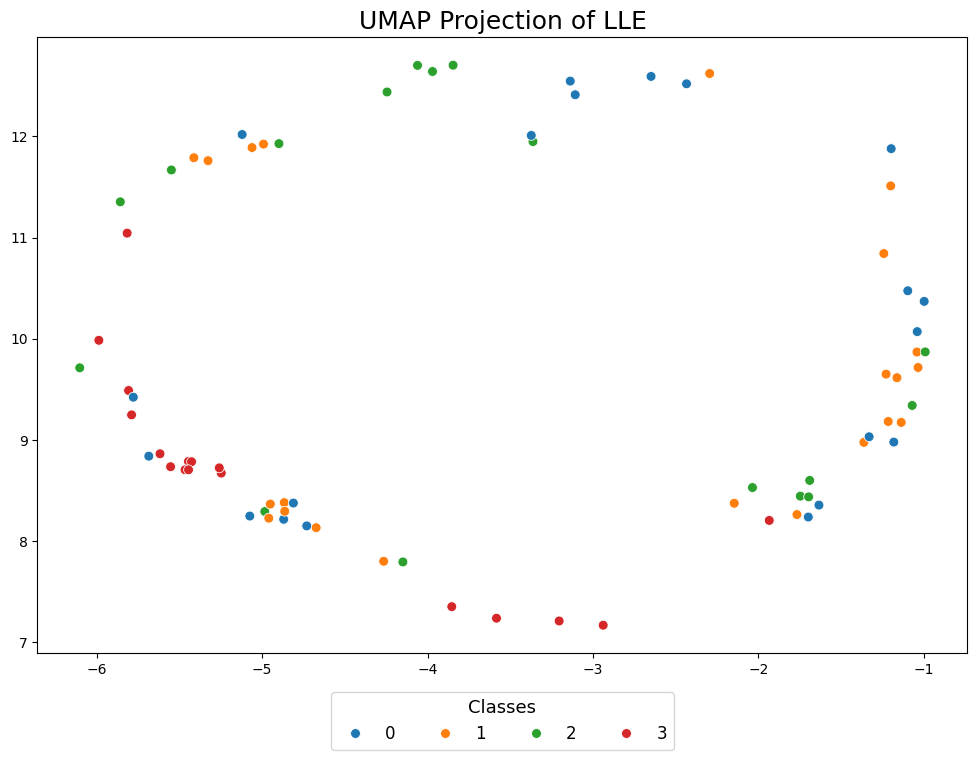

In [ ]:
plt_um.umap_plt(train_lle, val_lle, test_lle, ny_train, ny_val, ny_test, 'LLE')

In [ ]:
#UMAP Embedding
train_umap, val_umap, test_umap = embd.umap_embedding(train_sc, val_sc, test_sc)

In [ ]:
np.savetxt('tr_ep_umap_embeddings.txt', train_umap)
np.savetxt('te_ep_umap_embeddings.txt', test_umap)
np.savetxt('vl_ep_umap_embeddings.txt', val_umap)

In [ ]:
plt_um.umap_plt(train_sc, val_sc, test_sc, ny_train, ny_val, ny_test, 'Dataset')

In [ ]:
#AE Embedding
train_ae, val_ae, test_ae = embd.AE_embedding(train_sc, val_sc, test_sc)

In [ ]:
plt_um.umap_plt(train_ae, val_ae, test_ae, ny_train, ny_val, ny_test, 'AE')

In [ ]:
np.savetxt('tr_ep_ae_embeddings.txt', train_ae)
np.savetxt('te_ep_ae_embeddings.txt', test_ae)
np.savetxt('vl_ep_ae_embeddings.txt', val_ae)

In [ ]:
#nnclr_lstm embedding
#for the paper, 100 finetuning and training epochs were chosen, but here the example is done for 20 epochs
import nnclr_embd as nn
train_nn_lstm, val_nn_lstm, test_nn_lstm = nn.nnclr_lstm_embedding(train_sc, val_sc, test_sc,y_train_df-1,y_valid_df-1,y_test_df-1,64,7)

x_train_df shape: (151, 180)
y_train_df shape: (151,)
x_val_df shape: (76, 180)
y_val_df shape: (76,)
x_test_df shape: (76, 180)
y_test_df shape: (76,)


Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 180, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 180, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,400 (806.25 KB)

 Trainable params: 206,400 (806.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "nnclr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ contrastive_augmenter           │ (None, None, 1)        │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_augmenter        │ (None, None, 1)        │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_model (Sequential)      │ (None, 64)             │       206,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projection_head (Sequential)    │ (None, 64)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linear_probe (Sequential)       │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,175 (840.53 KB)

 Trainable params: 215,175 (840.53 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
3/3 - 10s - 3s/step - c_acc: 0.0378 - c_loss: 3.7771 - p_acc: 0.2763 - p_loss: nan - r_acc: 0.0547 - val_p_acc: 0.2895 - val_p_loss: nan
Epoch 2/20
3/3 - 0s - 47ms/step - c_acc: 0.0581 - c_loss: 3.7807 - p_acc: 0.2763 - p_loss: nan - r_acc: 0.1094 - val_p_acc: 0.2895 - val_p_loss: nan
Epoch 3/20
3/3 - 0s - 46ms/step - c_acc: 0.0116 - c_loss: 3.7841 - p_acc: 0.2763 - p_loss: nan - r_acc: 0.0755 - val_p_acc: 0.2895 - val_p_loss: nan
Epoch 4/20
3/3 - 0s - 47ms/step - c_acc: 0.0291 - c_loss: 3.7695 - p_acc: 0.2763 - p_loss: nan - r_acc: 0.0625 - val_p_acc: 0.2895 - val_p_loss: nan
Epoch 5/20
3/3 - 0s - 46ms/step - c_acc: 0.0378 - c_loss: 3.7287 - p_acc: 0.2763 - p_loss: nan - r_acc: 0.0703 - val_p_acc: 0.2895 - val_p_loss: nan
Epoch 6/20
3/3 - 0s - 48ms/step - c_acc: 0.0436 - c_loss: 3.7296 - p_acc: 0.2763 - p_loss: nan - r_acc: 0.0599 - val_p_acc: 0.2895 - val_p_loss: nan
Epoch 7/20
3/3 - 0s - 47ms/step - c_acc: 0.0407 - c_loss: 3.6821 - p_acc: 0.2763 - p_loss: nan - r_acc

In [16]:
namem="ECG5000_pca"

best_params, best_score = clasfy.optimize_LOGRG(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:49:03,075] A new study created in memory with name: no-name-a90c06a0-b817-495a-92a8-e1971d0cb4a0
[I 2025-04-25 15:49:03,097] Trial 0 finished with value: 0.5 and parameters: {'C': 1.3109715141203191e-05, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.7143156190601682}. Best is trial 0 with value: 0.5.
[I 2025-04-25 15:49:03,114] Trial 1 finished with value: 0.5 and parameters: {'C': 7.275546127089614e-10, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.2635890236189571}. Best is trial 0 with value: 0.5.
[I 2025-04-25 15:49:03,212] Trial 2 finished with value: 0.863013698630137 and parameters: {'C': 0.07152412061986935, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.8246182155604214}. Best is trial 2 with value: 0.863013698630137.
[I 2025-04-25 15:49:03,321] Trial 3 finished with value: 0.8561643835616438 and parameters: {'C': 0.09615093567102152, 'fit_intercept': False, 's

0.01563096046447754  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-49-14.txt
{'C': 0.4243058199782983, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.46116238734312126} 0.8571428571428571


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
best_params, best_score = clasfy.optimize_DT(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:49:23,941] A new study created in memory with name: no-name-c14c92a1-93cf-456b-b907-e7c64d5ebed3
[I 2025-04-25 15:49:23,950] Trial 0 finished with value: 0.7602739726027398 and parameters: {'max_depth': 23, 'criterion': 'gini'}. Best is trial 0 with value: 0.7602739726027398.
[I 2025-04-25 15:49:23,958] Trial 1 finished with value: 0.7534246575342466 and parameters: {'max_depth': 29, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7602739726027398.
[I 2025-04-25 15:49:23,966] Trial 2 finished with value: 0.7808219178082192 and parameters: {'max_depth': 32, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7808219178082192.
[I 2025-04-25 15:49:23,972] Trial 3 finished with value: 0.726027397260274 and parameters: {'max_depth': 3, 'criterion': 'log_loss'}. Best is trial 2 with value: 0.7808219178082192.
[I 2025-04-25 15:49:23,980] Trial 4 finished with value: 0.7534246575342466 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 2 with valu

0.0036721229553222656  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-49-25.txt
{'max_depth': 2, 'criterion': 'gini'} 0.8571428571428571


In [18]:
best_params, best_score = clasfy.optimize_RF(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)

[I 2025-04-25 15:49:45,769] A new study created in memory with name: no-name-6b43ecfb-e187-41b7-a3aa-06e6e5f1c8bd
[I 2025-04-25 15:49:46,062] Trial 0 finished with value: 0.8493150684931506 and parameters: {'n_estimators': 167, 'max_depth': 31}. Best is trial 0 with value: 0.8493150684931506.
[I 2025-04-25 15:49:46,175] Trial 1 finished with value: 0.863013698630137 and parameters: {'n_estimators': 65, 'max_depth': 7}. Best is trial 1 with value: 0.863013698630137.
[I 2025-04-25 15:49:46,197] Trial 2 finished with value: 0.7465753424657534 and parameters: {'n_estimators': 11, 'max_depth': 27}. Best is trial 1 with value: 0.863013698630137.
[I 2025-04-25 15:49:46,410] Trial 3 finished with value: 0.8013698630136986 and parameters: {'n_estimators': 122, 'max_depth': 8}. Best is trial 1 with value: 0.863013698630137.
[I 2025-04-25 15:49:46,701] Trial 4 finished with value: 0.910958904109589 and parameters: {'n_estimators': 188, 'max_depth': 4}. Best is trial 4 with value: 0.91095890410958

0.29011964797973633  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-50-05.txt
{'n_estimators': 188, 'max_depth': 4} 0.8299319727891157


In [19]:
best_params, best_score = clasfy.optimize_KNN(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:50:05,838] A new study created in memory with name: no-name-bd048d5e-1064-4145-bc0b-555a3195715c
[I 2025-04-25 15:50:05,844] Trial 0 finished with value: 0.8561643835616438 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.8561643835616438.
[I 2025-04-25 15:50:05,857] Trial 1 finished with value: 0.8698630136986302 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.8698630136986302.
[I 2025-04-25 15:50:05,909] Trial 2 finished with value: 0.7945205479452054 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 1 with value: 0.8698630136986302.
[I 2025-04-25 15:50:05,915] Trial 3 finished with value: 0.8493150684931506 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 1 with value: 0.8698630136986302.
[I 2025-04-25 15:50:05,927] Trial 4 finished with value: 0.8

0.009466886520385742  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-50-07.txt
{'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree'} 0.8435374149659864


In [20]:

best_params, best_score = clasfy.optimize_SVM(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:50:27,062] A new study created in memory with name: no-name-508a74e3-c73e-4b2c-87e4-fd2d20954c4b
[I 2025-04-25 15:50:27,073] Trial 0 finished with value: 0.863013698630137 and parameters: {'C': 0.6, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale'}. Best is trial 0 with value: 0.863013698630137.
[I 2025-04-25 15:50:27,213] Trial 1 finished with value: 0.8493150684931506 and parameters: {'C': 0.3, 'kernel': 'linear', 'degree': 3, 'gamma': 'auto'}. Best is trial 0 with value: 0.863013698630137.
[I 2025-04-25 15:50:27,353] Trial 2 finished with value: 0.8493150684931506 and parameters: {'C': 0.3, 'kernel': 'linear', 'degree': 3, 'gamma': 'auto'}. Best is trial 0 with value: 0.863013698630137.
[I 2025-04-25 15:50:27,361] Trial 3 finished with value: 0.863013698630137 and parameters: {'C': 1, 'kernel': 'rbf', 'degree': 2, 'gamma': 'scale'}. Best is trial 0 with value: 0.863013698630137.
[I 2025-04-25 15:50:27,640] Trial 4 finished with value: 0.8493150684931506 and parameters

0.00603485107421875  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-50-31.txt
{'C': 0.6, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale'} 0.8299319727891157


In [21]:
best_params, best_score = clasfy2.optimize_NB(train_pca, val_pca, test_pca,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-25 15:50:44,196] A new study created in memory with name: no-name-461588bc-2622-47fa-8dac-8360215c273b
[I 2025-04-25 15:50:44,201] Trial 0 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 2.038283912389982e-12}. Best is trial 0 with value: 0.8013698630136986.
[I 2025-04-25 15:50:44,204] Trial 1 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 5.666967735414902e-08}. Best is trial 0 with value: 0.8013698630136986.
[I 2025-04-25 15:50:44,207] Trial 2 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 7.84449094428711e-10}. Best is trial 0 with value: 0.8013698630136986.
[I 2025-04-25 15:50:44,210] Trial 3 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 1.1381655658146562e-10}. Best is trial 0 with value: 0.8013698630136986.
[I 2025-04-25 15:50:44,214] Trial 4 finished with value: 0.8013698630136986 and parameters: {'var_smoothing': 1.3254835312833236e-05}. Best is trial 0 with va

Best hyperparameters:  {'var_smoothing': 0.00926040057010399}
Best validation accuracy:  0.8767123287671232
Test accuracy: 0.8231292517006803
Time taken: 0.002248048782348633 seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-25_15-50-44.txt
{'var_smoothing': 0.00926040057010399} 0.8231292517006803
